# Use Logistic Regression



In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import datetime
%matplotlib inline

## Create Training Data

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
# Read picklefile

picklefile = 'oct_23.pkl'
df = pd.read_pickle(picklefile)

In [4]:
# Select columns of intrest from the DataFrame
# Cutting out all non-delta, non-expw columns
# with this call.
# May want to revise later to give option to use.
# Taking delta_ht out too because it results in too
# many NaNs.

df = df[['label', 'tourney_date', 'delta_age',
                    'delta_rank', 'delta_rank_points',
                    'delta_ace_expw', 'delta_df_expw',
                    'delta_svpt_expw', 'delta_1stIn_expw',
                    'delta_1stWon_expw', 'delta_2ndWon_expw',
                    'delta_SvGms_expw', 'delta_bpSaved_expw',
                    'delta_bpFaced_expw']].dropna()

In [5]:
df = df[df.tourney_date < datetime.date(2016,1,1)]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70155 entries, 3 to 83307
Data columns (total 14 columns):
label                 70155 non-null int64
tourney_date          70155 non-null datetime64[ns]
delta_age             70155 non-null float64
delta_rank            70155 non-null float64
delta_rank_points     70155 non-null float64
delta_ace_expw        70155 non-null float64
delta_df_expw         70155 non-null float64
delta_svpt_expw       70155 non-null float64
delta_1stIn_expw      70155 non-null float64
delta_1stWon_expw     70155 non-null float64
delta_2ndWon_expw     70155 non-null float64
delta_SvGms_expw      70155 non-null float64
delta_bpSaved_expw    70155 non-null float64
delta_bpFaced_expw    70155 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 8.0 MB


## Create Holdout Data

In [7]:
picklefile = 'oct_23_game_and_odds.pkl'
holdout = pd.read_pickle(picklefile)
holdout = holdout.drop('delta_ht', axis=1)
holdout = holdout.dropna()

## Train the Model

In [8]:
# Split DF into features, response.

Xcols = ['delta_age', 'delta_rank',
         'delta_rank_points', 'delta_ace_expw',
         'delta_df_expw', 'delta_svpt_expw',
         'delta_1stIn_expw', 'delta_1stWon_expw',
         'delta_2ndWon_expw', 'delta_SvGms_expw',
         'delta_bpSaved_expw', 'delta_bpFaced_expw']

ycols = 'label'

X_train = df[Xcols]
y_train = df[ycols]

In [9]:
X_test = holdout[Xcols]
y_test = holdout[ycols]

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train);

In [11]:
# Predicts 61.6% of games correctly.  Not bad!

lr.score(X_test, y_test)

0.61334745762711862

## Run Simulation

In [12]:
# i[1] is the predicted probability of result 1: player1 winning.

player1_probs = []
y_prob = lr.predict_proba(X_test)
for i in y_prob:
    player1_probs.append((i[1]))
len(player1_probs)

944

In [13]:
player2_probs = []
y_prob = lr.predict_proba(X_test)
for i in y_prob:
    player2_probs.append((i[0]))
len(player2_probs)

944

In [14]:
betting = pd.DataFrame(list(zip(player1_probs, player2_probs, holdout.player1_avg_odds, holdout.player2_avg_odds, y_test)),
                       columns=['model_odds1', 'model_odds2', 'bookie_odds1', 'bookie_odds2', 'result'])

In [15]:
betting['difference1'] = betting.model_odds1 - betting.bookie_odds1
betting['difference2'] = betting.model_odds2 - betting.bookie_odds2

In [16]:
betting.head()

,model_odds1,model_odds2,bookie_odds1,bookie_odds2,result,difference1,difference2
0,0.920428,0.079572,0.796826,0.248631,0,0.123601,-0.169059
1,0.979911,0.020089,0.906112,0.141230,1,0.073799,-0.121142
2,0.786850,0.213150,0.668209,0.379469,1,0.118640,-0.166319
3,0.954960,0.045040,0.841296,0.203554,1,0.113664,-0.158514
4,0.844515,0.155485,0.847144,0.203377,1,-0.002629,-0.047892


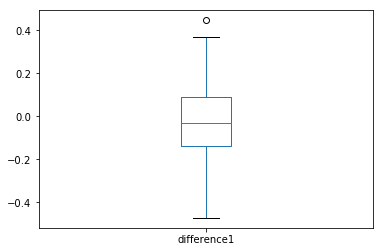

In [18]:
betting.difference1.plot(kind='box');

In [19]:
purse = 100
betting_fraction = .01
full_track = []
track = []

for i in range(len(betting)):
    winnings = 0
    bet = 0
    
    if betting.difference1[i] > 0:
        # Betting on player 1
        bet = purse * betting_fraction
        if betting.result[i] == 1:
            winnings = bet * (1 / (betting.bookie_odds1[i]))
            purse += winnings
        else:
            winnings = -bet
            purse += winnings
            
    if betting.difference2[i] > 0:
        # Betting on player 2
        bet = purse * betting_fraction
        if betting.result[i] == 0:
            winnings = bet * (1 / (betting.bookie_odds2[i]))
            purse += winnings
        else:
            winnings = -bet
            purse += winnings
    
    full_track.append((purse, bet, winnings))
    track.append(purse)

In [40]:
betting.tail(10)

,model_odds1,model_odds2,bookie_odds1,bookie_odds2,result,difference1,difference2
934,0.495942,0.504058,0.551920,0.502202,1,-0.055978,0.001856
935,0.118194,0.881806,0.429306,0.623166,0,-0.311112,0.258640
936,0.582398,0.417602,0.778441,0.273349,1,-0.196043,0.144253
937,0.485103,0.514897,0.345797,0.707664,1,0.139306,-0.192768
938,0.487046,0.512954,0.550031,0.503478,1,-0.062985,0.009475
939,0.431096,0.568904,0.477507,0.576381,1,-0.046411,-0.007478
940,0.616011,0.383989,0.473282,0.580193,0,0.142729,-0.196204
941,0.869739,0.130261,0.869142,0.183348,0,0.000597,-0.053087
942,0.179564,0.820436,0.296568,0.749143,0,-0.117004,0.071294
943,0.110009,0.889991,0.191576,0.858815,0,-0.081566,0.031176


In [44]:
full_track[-10:]

[(1445.2680474772046, 14.598667146234391, -14.598667146234391),
 (1468.4603939298875, 14.452680474772047, 23.192346452682813),
 (1453.7757899905887, 14.684603939298874, -14.684603939298874),
 (1495.81712357477, 14.537757899905888, 42.041333584181267),
 (1480.8589523390224, 14.958171235747701, -14.958171235747701),
 (1480.8589523390224, 0, 0),
 (1466.0503628156321, 14.808589523390225, -14.808589523390225),
 (1451.3898591874758, 14.66050362815632, -14.66050362815632),
 (1470.7638749241573, 14.513898591874758, 19.374015736681574),
 (1487.8893842482446, 14.707638749241573, 17.125509324087364)]

In [43]:
track[-10:]

[1445.2680474772046,
 1468.4603939298875,
 1453.7757899905887,
 1495.81712357477,
 1480.8589523390224,
 1480.8589523390224,
 1466.0503628156321,
 1451.3898591874758,
 1470.7638749241573,
 1487.8893842482446]

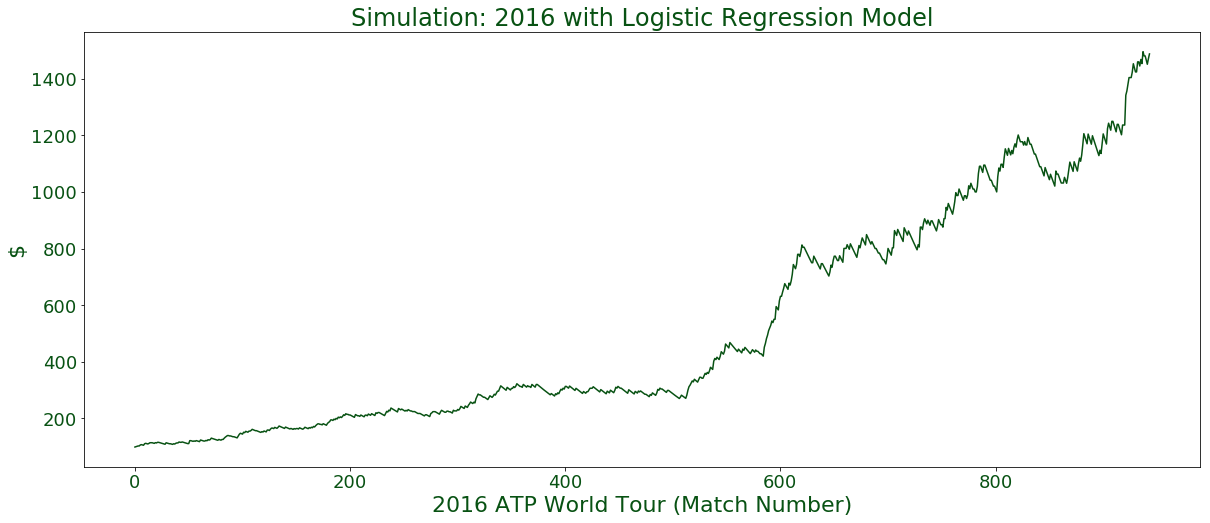

In [39]:
plt.figure(figsize=(20,8))
plt.title("Simulation: 2016 with Logistic Regression Model", fontsize=24, color='#085213')
plt.xlabel("2016 ATP World Tour (Match Number)", fontsize=22, color='#085213')
plt.ylabel("$", fontsize=22, color='#085213')
plt.xticks(fontsize=18, color='#085213')
plt.yticks(fontsize=18, color='#085213')
plt.plot(track, color='#085213');